In [1]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC, Accuracy
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve,\
                            average_precision_score, accuracy_score, f1_score,\
                            precision_score, recall_score, classification_report
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from torchvision.models.efficientnet import efficientnet_b0 as Model
from torchvision.models.efficientnet import EfficientNet_B0_Weights as ModelW
from torchvision.models.efficientnet import EfficientNet

In [3]:
import sys
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [4]:
import explainer.rule_pattern_miner as rlm
import explainer.explainer_utils as eutils
from explainer.integrad import integrad
from explainer.itemsets_miner import transform_intgrad_to_itemsets,gen_freq_feature_set
import explainer.integrad as integrad

In [5]:
OPTIM_PARAMS = {"lr":1e-4}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 16
IMAGE_SIZE = 256
N_EPOCHS = 50
PATIENCE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if DEVICE=='cuda' else 4 # fixed by kaggle notebook
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
class ENet(torch.nn.Module):
    
    def __init__(self,model):
        super().__init__()
        self.net = model
        self.features = torch.nn.Sequential(model.features,model.avgpool)
        self.avgpool = model.avgpool
        self.classifier = model.classifier
    
    def latent_representation(self,x):
        ### from features to output ###
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward(self,x):
        return self.net.forwad(x)
    
        

In [7]:
class ENetUpper(ENet):
    
    
    def latent_representation(self,x):
        ### from input to features ###
        x = self.features(x)
        return x


In [8]:
data_dir = '../../data/BrainTumors/raw'
output_dir = '../../data/BrainTumors/processed'

In [9]:
!ls -al '../../data/BrainTumors/raw'

total 0
drwxr-xr-x  6 chenyu  staff  192 Nov  6 15:43 .
drwxr-xr-x@ 5 chenyu  staff  160 Oct 26 13:26 ..
drwxr-xr-x@ 2 chenyu  staff   64 Oct 26 13:26 glioma_tumor
drwxr-xr-x@ 2 chenyu  staff   64 Oct 26 13:26 meningioma_tumor
drwxr-xr-x@ 2 chenyu  staff   64 Oct 26 13:26 normal
drwxr-xr-x@ 2 chenyu  staff   64 Oct 26 13:26 pituitary_tumor


In [10]:
### for first time process the raw data

if not os.path.exists(output_dir):

    train_percent = 0.7
    val_percent = 0.1
    test_percent = 0.2

    for root, dirs, files in os.walk(data_dir):
        print(root, dirs,files, len(files))
        if len(files) > 0:
            train_files, temp_files = train_test_split(files, test_size=(1 - train_percent), random_state=SEED)
            val_files, test_files = train_test_split(temp_files, test_size=(test_percent / (test_percent + val_percent)), random_state=SEED)
            for split_name,files in zip(["train","val","test"],[train_files,val_files,test_files]):
                new_output_dir = os.path.join(output_dir, split_name, os.path.relpath(root, data_dir))
                os.makedirs(new_output_dir, exist_ok=True)
                #print(new_output_dir)
                for file in files:
                    src = os.path.join(root, file)
                    dst = os.path.join(new_output_dir, file)
                    shutil.move(src, dst)

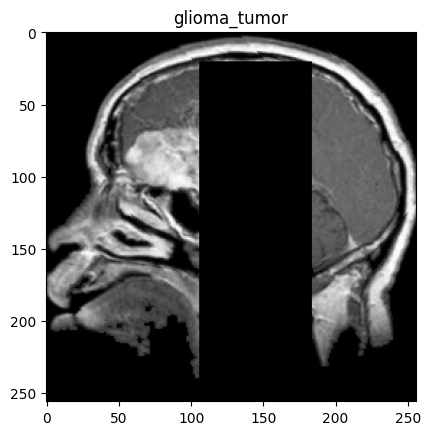

In [11]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(),
                                     ])

transform_val = transforms.Compose([transforms.ToTensor(),])

train = ImageFolder(os.path.join(output_dir,"train"),
                    transform=transform_train,
                   )

val = ImageFolder(os.path.join(output_dir,"val"),
                    transform=transform_val,
                   )

test = ImageFolder(os.path.join(output_dir,"test"),
                    transform=transform_val,
                   )

class_names = train.classes

plt.imshow(train[0][0].transpose(0,2).transpose(1,0))
plt.title(train.classes[train[0][1]])
plt.show()

In [12]:
# loaders :
train_loader = DataLoader(train,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
val_loader = DataLoader(val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)

In [13]:
model = Model(weights=ModelW.IMAGENET1K_V1)

In [14]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features,out_features=4)

In [16]:
### load the saved model if not the first time training it

model_path = './results/BrainTumors/efficient_net'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(DEVICE)
    model.eval()
    
else:
    model.to(DEVICE)

    optimizer = OPTIM(model.parameters(),**OPTIM_PARAMS)
    criterium = CRITERIUM()

    best_model = deepcopy(model)
    best_acc = 0
    patience = 0

    for epoch in range(N_EPOCHS):
        train_loss = 0
        train_total = 0
        model.train()
        for x,y in tqdm(train_loader):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = model(x)
            loss = criterium(output,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            train_total += x.size(0)
        train_loss /= train_total

        val_loss = 0
        val_total = 0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                output = model(x)
                loss = criterium(output,y)
                val_loss += loss.item() * x.size(0)
                val_total += x.size(0)
                val_acc += torch.sum(torch.argmax(output,dim=-1)==y).item()
        val_loss /= val_total
        val_acc /= val_total


        # save
        if val_acc > best_acc :
            best_acc = val_acc
            best_model = deepcopy(model)
            patience = 0
        else :
            patience += 1

        print("Epoch {} : train loss {:.4f} | val loss {:.4f} | val Acc {:.3f}".format(epoch,
                                                                                       train_loss,
                                                                                       val_loss,
                                                                                       val_acc))

        # earlystopping
        if patience >= PATIENCE :
            break
    torch.save(best_model.state_dict(), model_path)
    model = best_model
    model.eval()

In [17]:
y_true, y_pred = [], []

with torch.no_grad():
    for x,y in tqdm(test_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x).softmax(dim=-1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(output.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|███████████████████████████████████████████| 39/39 [01:19<00:00,  2.03s/it]


In [18]:
y_pred_labels = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_true, y_pred_labels)
report = classification_report(y_true, y_pred_labels, target_names=class_names,zero_division=0)
print(report)
print(f'Accuracy: {accuracy:.2f}')

                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.91      0.93       181
meningioma_tumor       0.90      0.96      0.93       183
          normal       0.97      0.98      0.97        88
 pituitary_tumor       0.99      0.96      0.98       170

        accuracy                           0.95       622
       macro avg       0.95      0.95      0.95       622
    weighted avg       0.95      0.95      0.95       622

Accuracy: 0.95


In [19]:
train_val = ImageFolder(os.path.join(output_dir,"train"),
                    transform=transform_val,
                   )
train_val_loader = DataLoader(train_val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)

In [20]:
emodel = ENet(model)
torch.manual_seed(SEED)


correct = 0
total = 0
X_train, X_train_raw = [],[]
y_train, pred_y_train = [],[]
train_reps = []
with torch.no_grad():
    for data in train_val_loader:
        inputs, labels = data
        
        X_train_raw.append(inputs)
        X_train.append(emodel.features(inputs).detach())
        y_train.append(labels)        
        
        outputs = model(inputs).detach()
        train_reps.append(outputs) 
        predicted = torch.argmax(outputs,dim=1)
        pred_y_train.append(predicted)        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
X_train = torch.vstack(X_train)
X_train_raw = torch.vstack(X_train_raw)
train_reps = torch.vstack(train_reps)

y_train = torch.concat(y_train).numpy()
pred_y_train = torch.concat(pred_y_train).numpy()

print(f'Accuracy on the training set: {100 * correct / total:.2f}%')

Accuracy on the training set: 99.58%


In [21]:
((pred_y_train==0)&(y_train==0)).sum()/(y_train==0).sum()

0.9952305246422893

In [22]:
baselines = eutils.gen_intgrad_baselines(X_train,y_train,train_reps)
subset = eutils.gen_balanced_subset(X_train,y_train,size_per_class=300)
int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=emodel,baselines=baselines,C=4)

In [23]:
y_int_g = []
C=4
n_c = int(len(int_g)/C)
int_g = int_g.squeeze()
for c in range(C):
    tmp = torch.abs(int_g[c*n_c:(c+1)*n_c,:]/z_shift[c*n_c:(c+1)*n_c,c].reshape(-1,1))
    tmp[torch.isnan(tmp)] = 0.
    
    y_int_g.append(tmp)

In [24]:
train.class_to_idx

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}

In [25]:
### specify the target class for generating rules
c = 2

int_g, z_shift = eutils.calc_baselines_intg(test_examples=subset,model=emodel,baselines=baselines,C=4,target_dim=c)
y_int_g = torch.abs(int_g.squeeze()/z_shift[:,c].reshape(-1,1))

In [26]:
y_int_g.shape

torch.Size([900, 1280])

In [27]:
### search int_g score threshold
thds = np.linspace(0.0001,0.1,1000)
f_n = []
for thd in thds:
    mask = torch.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(dim=0)>=len(y_int_g)*0.9).sum()))
    print(f_n[-1])
    if f_n[-1][1]<=1:
        break
thd = f_n[-1][0]
thd

(0.0001, tensor(377))
(0.0002, tensor(179))
(0.00030000000000000003, tensor(94))
(0.0004, tensor(47))
(0.0005, tensor(27))
(0.0006000000000000001, tensor(13))
(0.0007000000000000001, tensor(7))
(0.0008, tensor(4))
(0.0009000000000000001, tensor(4))
(0.001, tensor(3))
(0.0011, tensor(1))


0.0011

In [28]:
thd

0.0011

In [29]:
### seatch frequent features

itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=100,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

[116.0] 817.0
[116.0, 1201.0] 767.0
[116.0, 1201.0, 1139.0] 689.0
[116.0, 1201.0, 1139.0, 394.0] 644.0
[116.0, 1201.0, 1139.0, 394.0, 490.0] 555.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0] 480.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0, 1210.0] 391.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0, 1210.0, 660.0] 316.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0, 1210.0, 660.0, 121.0] 273.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0, 1210.0, 660.0, 121.0, 1231.0] 203.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0, 1210.0, 660.0, 121.0, 1231.0, 1061.0] 175.0
[116.0, 1201.0, 1139.0, 394.0, 490.0, 76.0, 1210.0, 660.0, 121.0, 1231.0, 1061.0, 1260.0] 141.0
feature set [ 115 1200 1138  393  489   75 1209  659  120 1230 1060 1259] 12


In [30]:
(y_train==c).sum()

306

In [80]:
if c!= 2:
    min_support = 500   
    num_grids = 10
    max_depth = 1
else:
    min_support = 250   
    num_grids = 10
    max_depth = 2
    
X_train = X_train.squeeze()



y_rule_candidates = rlm.gen_rule_list_for_one_target(X_train.numpy(),fids,pred_y_train==c,y=y_train,c=c,sort_by="cond_prob_target",
                                                            min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=3,
                                                            local_x=None,feature_types=None,search="greedy",
                                                            verbose=False)


y_rule_candidates

build_rule_tree
init rule tree
search rule for feature 115
search rule for feature 1200
search rule for feature 1138
search rule for feature 393
search rule for feature 489
search rule for feature 75
search rule for feature 1209
search rule for feature 659
search rule for feature 120
search rule for feature 1230
search rule for feature 1060
search rule for feature 1259
best rule 115 6.588235294117648
check potential rule 115 6.588235294117648 0.7960024972756703 2.814511299133301 270
add rule [] 115 (6.588235294117648, 0.7960024972756703, 2.814511299133301, 270)
search rule for feature 1200
search rule for feature 1138
search rule for feature 393
search rule for feature 489
search rule for feature 75
search rule for feature 1209
search rule for feature 659
search rule for feature 120
search rule for feature 1230
search rule for feature 1060
search rule for feature 1259
best rule 1060 1.0542857142857143
check potential rule 1060 1.0542857142857143 0.08511673079596627 2.5065696239471436 2

[{'rules': [(115, '>=', 0.7960024972756703),
   (1060, '>=', 0.08511673079596627)],
  'cond_prob_target': 0.984,
  'support': 250,
  'cond_prob_y': 0.984,
  'ratio_y': 0.803921568627451}]

In [81]:
r1 = y_rule_candidates[0]["rules"]
r=r1[0]

seen = set()
keys = [r[0] for r in r1 if not (r[0] in seen or seen.add(r[0]))]

rdict = {}
for key in keys:
    for r in r1:
        if r[0] == key:
            rdict[key] = rdict.get(key,[])
            rdict[key].append(r)
rdict

{115: [(115, '>=', 0.7960024972756703)],
 1060: [(1060, '>=', 0.08511673079596627)]}

In [82]:
prefix = "./results/BrainTumors/c"+str(c)+"_sp"+str(min_support)
if not os.path.exists(prefix):
    os.mkdir(prefix)

In [83]:
file_type = ".svg"

In [41]:
# tot_img = []


# for kk,fid in enumerate(keys):
#     rs = rdict[fid]
#     ids = torch.ones(len(X_train)).bool()
#     for r in rs:
#         print(r)
#         ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
#     imgs = X_train_raw[ids]
#     lbs = y_train[ids]
#     plbs = pred_y_train[ids]
#     print(rs,"support",ids.sum())
    
#     # Create a figure with 16 subplots
#     fig, axes = plt.subplots(4, 4, figsize=(8, 8))

#     for i in range(4):
#         for j in range(4):
#             index = i * 4 + j
#             image = imgs[index]
#             axes[i, j].imshow(image.transpose(0,2).transpose(1,0))
#             axes[i, j].set_title(f"Label: {lbs[index]}")
#             axes[i, j].axis('off')
# #     plt.savefig(os.path.join(prefix,"rule_samples_c"+str(c)+"r"+str(kk)+file_type),bbox_inches="tight")
#     plt.show()
    
#     plt.close()
    
#     avg_img = imgs.mean(axis=0).squeeze()

    
#     tot_img.append(avg_img.reshape(1,3,256,256))
#     plt.imshow(avg_img.transpose(0,2).transpose(1,0))

    
# #     plt.savefig(os.path.join(prefix,"rule_average_c"+str(c)+"r"+str(kk)+file_type),bbox_inches="tight")
#     plt.show()
#     plt.close

    

In [42]:
# ids = torch.ones(len(X_train)).bool()
# for rv in rdict.values():    
#     for r in rv:
#         ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
# imgs = X_train_raw[ids] 
# lbs = y_train[ids]

# fig, axes = plt.subplots(4, 4, figsize=(8, 8))

# for i in range(4):
#     for j in range(4):
#         index = i * 4 + j
#         image = imgs[index]
#         axes[i, j].imshow(image.transpose(0,2).transpose(1,0))
#         axes[i, j].set_title(f"Label: {lbs[index]}")        
#         axes[i, j].axis('off')
# plt.savefig(os.path.join(prefix,"tot_rule_samples_c"+str(c)+file_type),bbox_inches="tight")

In [34]:
emodel_upper = ENetUpper(model)

In [35]:
raw_baselines = eutils.gen_intgrad_baselines(X_train_raw,y_train)

In [37]:
# for index in range(16):
#     print(index)
#     cids = np.arange(C)
#     k = lbs[index]
#     test_sample = imgs[index].unsqueeze(0)
#     for ii,rdim in enumerate(keys):
#         s_int_g,s_latent_shift = [],[]
#         for kk in cids[cids!=k]:
#             s_int_g_kk,s_latent_shift_kk = integrad.integrad(test_examples=test_sample,model=emodel_upper, 
#                                                       input_baseline=raw_baselines[kk],n_bins=100,target_dim=rdim)
#             s_int_g.append(s_int_g_kk)
#             s_latent_shift.append(s_latent_shift_kk)

#         s_int_g = torch.vstack(s_int_g)
#         s_latent_shift = torch.vstack(s_latent_shift)
        
#         s_int_g_avg = torch.abs(s_int_g/s_latent_shift[:,rdim,:,:]).mean(axis=0)
#         s_int_g_avg = s_int_g_avg/s_int_g_avg.max()
#         tmp = s_int_g_avg+imgs[index]
#         tmp = (tmp - tmp.min())/(tmp.max()-tmp.min())
#         plt.imshow(tmp.transpose(0,2).transpose(1,0))
#         plt.savefig(os.path.join(prefix,"rule_gsample_c"+str(c)+"r"+str(ii)+"_img"+str(index)+file_type),bbox_inches="tight")
#         plt.show()
#         plt.close()
#         print(rdim,ii)

In [38]:
# cids = np.arange(C)
# for kk,fid in enumerate(keys):
#     rs = rdict[fid]
#     ids = torch.ones(len(X_train)).bool()
#     for r in rs:
#         print(r)
#         ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
#     imgs = X_train_raw[ids]
#     lbs = y_train[ids]
#     plbs = pred_y_train[ids]

#     for index in range(16):
#         print(index)        
#         k = lbs[index]
#         test_sample = imgs[index].unsqueeze(0)
#         s_int_g,s_latent_shift = [],[]
#         for ci in cids[cids!=k]:
#             s_int_g_i,s_latent_shift_i = integrad.integrad(test_examples=test_sample,model=emodel_upper, 
#                                                       input_baseline=raw_baselines[ci],n_bins=100,target_dim=fid)
#             s_int_g.append(s_int_g_i)
#             s_latent_shift.append(s_latent_shift_i)

#         s_int_g = torch.vstack(s_int_g)
#         s_latent_shift = torch.vstack(s_latent_shift)
        
#         s_int_g_avg = torch.abs(s_int_g/s_latent_shift[:,fid,:,:]).mean(axis=0)
#         s_int_g_avg = s_int_g_avg/s_int_g_avg.max()
#         tmp = s_int_g_avg+imgs[index]
#         tmp = (tmp - tmp.min())/(tmp.max()-tmp.min())
#         plt.imshow(tmp.transpose(0,2).transpose(1,0))
#         plt.savefig(os.path.join(prefix,"single_rule_gsample_c"+str(c)+"r"+str(kk)+"_img"+str(index)+file_type),bbox_inches="tight")
#         plt.show()
#         plt.close()
#         print(fid,index)

(115, '>=', 0.7960024972756703)
(1060, '>=', 0.08511673079596627)
incorrect, true 0 predict 0


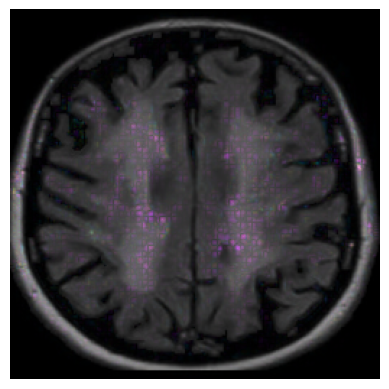

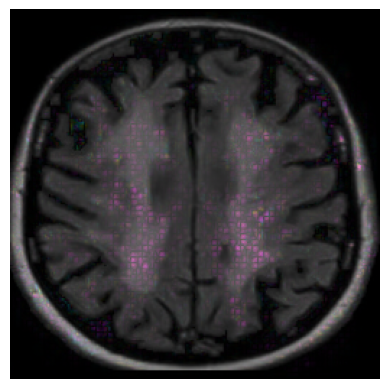

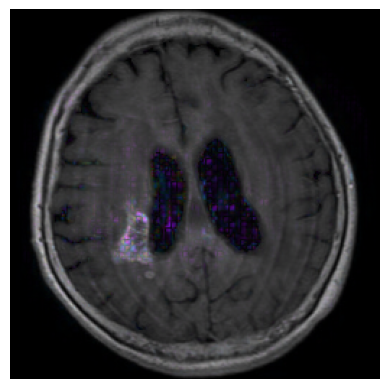

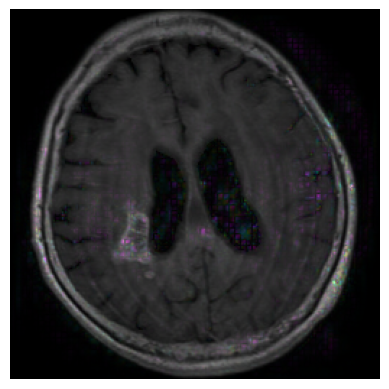

In [109]:
cids = np.arange(C)
k =  c
tn = ["_correct_","_incorrect_"]
ids = torch.ones(len(X_train)).bool()
for kk,fid in enumerate(keys):
    rs = rdict[fid]    
    for r in rs:
        print(r)
        ids = rlm.op_map[r[1]](X_train[:,r[0]],r[2]) & ids
imgs = X_train_raw[ids]
lbs = y_train[ids]
plbs = pred_y_train[ids]
    
correct = imgs[(lbs==plbs)&(plbs==c)][0]
incorrect = imgs[(plbs!=c)][-1]
print("incorrect, true",lbs[(plbs!=c)][-1],"predict",plbs[(plbs!=c)][-1])

for t, test_sample in enumerate([correct,incorrect]):
    for kk,fid in enumerate(keys):
        test_sample = test_sample.unsqueeze(0)
        s_int_g,s_latent_shift = [],[]
        for ci in cids[cids!=k]:
            s_int_g_i,s_latent_shift_i = integrad.integrad(test_examples=test_sample,model=emodel_upper, 
                                                      input_baseline=raw_baselines[ci],n_bins=100,target_dim=fid)
            s_int_g.append(s_int_g_i)
            s_latent_shift.append(s_latent_shift_i)

        s_int_g = torch.vstack(s_int_g)
        s_latent_shift = torch.vstack(s_latent_shift)

        s_int_g_avg = torch.abs(s_int_g/s_latent_shift[:,fid,:,:]).mean(axis=0)
        s_int_g_avg = s_int_g_avg/s_int_g_avg.max()
        
        test_sample = test_sample.squeeze()
        tmp = s_int_g_avg+test_sample
        tmp = (tmp - tmp.min())/(tmp.max()-tmp.min())
        plt.axis('off')
        plt.imshow(tmp.transpose(0,2).transpose(1,0))
        
        plt.savefig(os.path.join(prefix,"single_rule_gsample_c"+str(c)+tn[t]+"r"+str(kk)+"_img"+str(index)+file_type),bbox_inches="tight")
        plt.show()
        plt.close()
    


In [85]:
(plbs!=c).sum()

4

In [92]:
incorrect = imgs[(plbs!=c)][3]

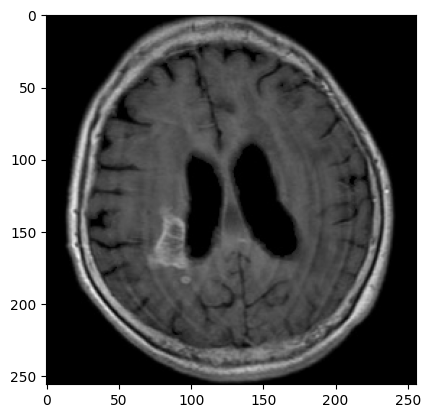

In [93]:
plt.imshow(incorrect.transpose(0,2).transpose(1,0))

In [107]:
correct = imgs[(lbs==plbs)&(plbs==c)][4]

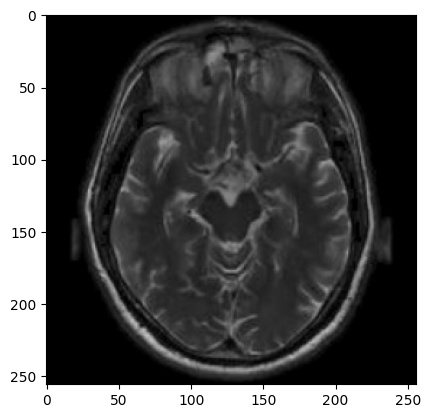

In [108]:
plt.imshow(correct.transpose(0,2).transpose(1,0))

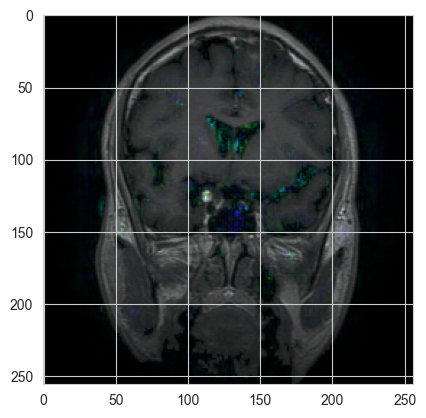

In [433]:
tmp = s_int_g_avg+imgs[index]
tmp = (tmp - tmp.min())/(tmp.max()-tmp.min())
plt.imshow(tmp.transpose(0,2).transpose(1,0))

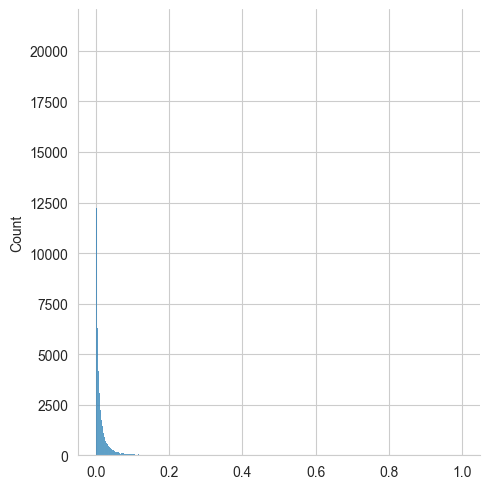

In [422]:
sns.displot(s_int_g_avg.reshape(-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


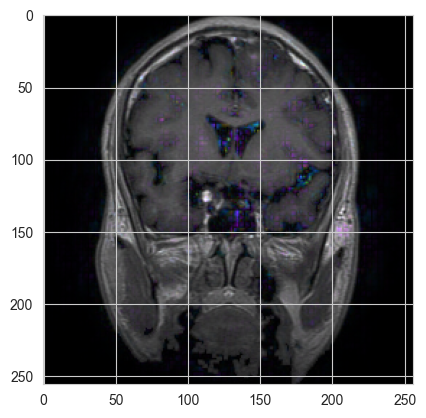

In [423]:

# plt.colorbar()

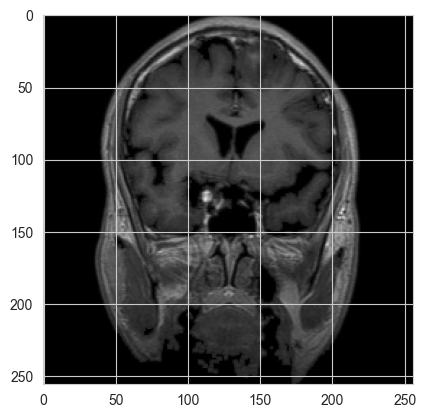

In [424]:
plt.imshow(imgs[index].transpose(0,2).transpose(1,0))

In [425]:
cids = np.arange(C)
k = lbs[index]
test_sample = imgs[index].unsqueeze(0)
s_int_g,s_latent_shift = [],[]
for kk in cids[cids!=k]:
    s_int_g_kk,s_latent_shift_kk = integrad.integrad(test_examples=test_sample,model=emodel_upper, 
                                              input_baseline=raw_baselines[kk],n_bins=100,target_dim=1200)
    s_int_g.append(s_int_g_kk)
    s_latent_shift.append(s_latent_shift_kk)
    
s_int_g = torch.vstack(s_int_g)
s_latent_shift = torch.vstack(s_latent_shift)

In [426]:
s_int_g_avg = torch.abs(s_int_g/s_latent_shift[:,1200,:,:]).mean(axis=0) 

In [427]:
s_int_g_avg = s_int_g_avg/s_int_g_avg.max()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


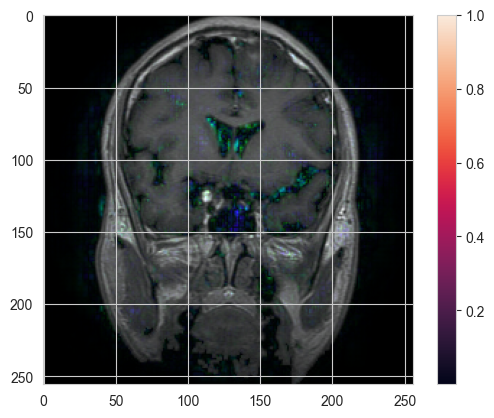

In [432]:
# plt.imshow((s_int_g_avg).transpose(0,2).transpose(1,0))
plt.imshow((imgs[index]+s_int_g_avg).transpose(0,2).transpose(1,0))
plt.colorbar()

In [460]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.tree import plot_tree,export_text,export_graphviz
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

In [461]:
feature_names = ["z"+str(i) for i in range(X_train.shape[1])]

In [524]:
treemodel = DecisionTreeClassifier(max_depth=2,min_samples_leaf=200,random_state=SEED)
treemodel.fit(X_train,pred_y_train==c)

rule_list, rule_value_list, rule_support_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.numpy(),y_train,pred_y_train==c,np.arange(X_train.shape[-1]),feature_names,c=c)
len(rule_list)

3

In [525]:
print(export_text(treemodel))

|--- feature_115 <= 0.78
|   |--- feature_1115 <= -0.13
|   |   |--- class: False
|   |--- feature_1115 >  -0.13
|   |   |--- class: False
|--- feature_115 >  0.78
|   |--- class: True



In [526]:
## print rules from DecisionTreeClassifier
select = [[],[],[]]
for s in range(len(rule_list)):
    select[0].append(rule_list[s])
    select[2].append(rule_support_list[s])
    print('#################')
    print(rule_list[s])
    print('cond_prob_target',rule_support_list[s][1].round(3),'cond_prob_y',rule_support_list[s][2].round(3),'size',rule_support_list[s][0])
    for r in rule_list[s]:
        print(feature_names[r[0]],r[1],r[2])

#################
[(115, '<=', 0.781), (1115, '<=', -0.134)]
cond_prob_target 0.241 cond_prob_y 0.236 size 203
z115 <= 0.781
z1115 <= -0.134
#################
[(115, '<=', 0.781), (1115, '>', -0.134)]
cond_prob_target 0.001 cond_prob_y 0.001 size 1684
z115 <= 0.781
z1115 > -0.134
#################
[(115, '>', 0.781)]
cond_prob_target 0.93 cond_prob_y 0.93 size 273
z115 > 0.781
